# VGGish11 Sound Classification Inference

This notebook demonstrates an end-to-end sound classification pipeline using VGGish11 (VGG11-based model, INT8 quantization) compiled with TIDL.

In [1]:
import os
import sys
import time
import warnings
from pathlib import Path

# Suppress ONNX Runtime GPU discovery warning
os.environ['ORT_DISABLE_DEVICE_DISCOVERY'] = '1'
# Suppress SyntaxWarning from onnxruntime library (invalid escape sequences in Python 3.12)
warnings.filterwarnings('ignore', message='invalid escape sequence', category=SyntaxWarning)

import numpy as np
import soundfile as sf
import onnxruntime as ort
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import vggish_infer_audio as via

# Environment setup
SOC = os.environ.get("SOC")
if not SOC:
    print("Warning: SOC environment variable not defined. Using 'am62a' as default.")
    SOC = 'am62a'

WORK_DIR = Path(__file__).parent.parent.parent if '__file__' in globals() else Path.cwd().parent.parent
WORK_DIR = WORK_DIR.resolve()

# Import configuration from via module
TIDL_VER = via.TIDL_VER
DEFAULT_MODEL = via.DEFAULT_MODEL
CLASS_LABELS = via.CLASS_LABELS
AUDIO_CONFIG = via.AUDIO_CONFIG_DEFAULT

print(f"Setup complete: SOC='{SOC}', TIDL_VER='{TIDL_VER}'")

Setup complete: SOC='am62a', TIDL_VER='11_02_02_00'


## Configuration

Set the parameters for the inference process.

In [2]:
# Configuration
model_name = DEFAULT_MODEL
tensor_bits = 8
debug_level = 0

# Set up paths
base_artifacts_folder = WORK_DIR / 'model_artifacts' / TIDL_VER / SOC
models_base_path = WORK_DIR / 'models' / 'onnx'
audio_file_path = WORK_DIR / 'inference' / 'vggish11_sc' / 'sample_wav' / '139951-9-0-9.wav'

model_path = models_base_path / f"{model_name}.onnx"
artifacts_path = base_artifacts_folder / f"{model_name}_int{tensor_bits}"

print(f"Audio file: {audio_file_path.name}")
print(f"Model: {model_path.name}")
print(f"Artifacts: {artifacts_path}")

# Set environment variables for performance stats
os.environ["TIDL_RT_PERFSTATS"] = "1"
import platform
if platform.machine() == 'aarch64':
    os.environ["TIDL_RT_DDR_STATS"] = "1"
    print("TIDL DDR stats enabled")
else:
    print("Warning: Not running on aarch64 platform")

Audio file: 139951-9-0-9.wav
Model: vggish11_20250324-1807_ptq.onnx
Artifacts: /root/tidl/audioai-modelzoo/model_artifacts/11_02_02_00/am62a/vggish11_20250324-1807_ptq_int8
TIDL DDR stats enabled


## Load and Play Audio

Load the specified audio file and provide playback controls.

In [3]:
# Load audio file
waveform_np, sr_native = sf.read(str(audio_file_path), dtype='float32')

# Convert stereo to mono if needed
if waveform_np.ndim > 1:
    waveform_np = np.mean(waveform_np, axis=1)

print(f"Audio loaded: {len(waveform_np)} samples at {sr_native} Hz")

# Display audio player (use filename for compatibility)
display(Audio(filename=str(audio_file_path)))

Audio loaded: 176400 samples at 44100 Hz


Plot the waveform of the loaded audio signal.

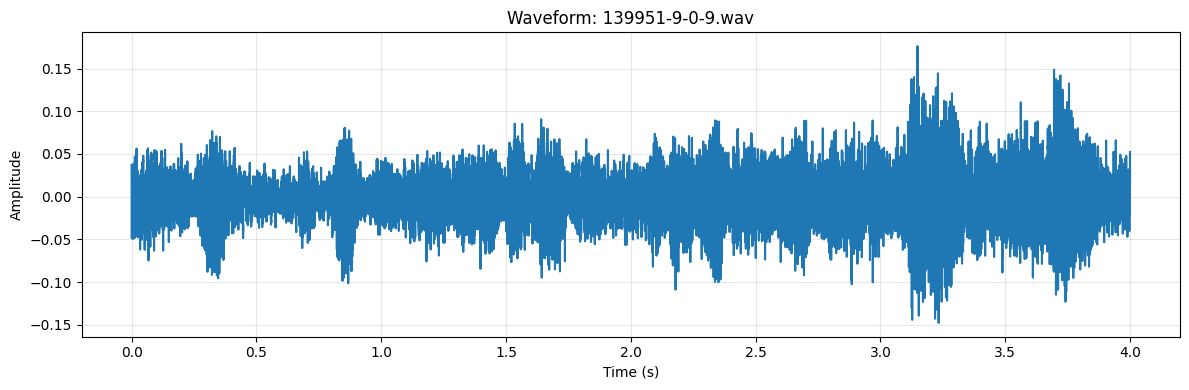

In [4]:
# Plot waveform
num_samples = len(waveform_np)
time_axis = np.linspace(0, num_samples / sr_native, num_samples)

plt.figure(figsize=(12, 4))
plt.plot(time_axis, waveform_np)
plt.title(f'Waveform: {audio_file_path.name}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Preprocess Audio and Extract Features

Resample, pad/truncate, and convert the audio waveform into a log mel spectrogram using the imported function.

In [5]:
# Preprocess audio and extract features
features, audio_duration = via.preprocess_audio_to_features(str(audio_file_path), AUDIO_CONFIG)
print(f"Features shape: {features.shape}")
print(f"Audio duration: {audio_duration:.2f} seconds")


Processing audio file: /root/tidl/audioai-modelzoo/inference/vggish11_sc/sample_wav/139951-9-0-9.wav
  Waveform shape: torch.Size([1, 64000])
  Log mel spectrogram shape: torch.Size([1, 64, 126])
  Total preprocessing time: 74.59 ms
Features shape: (1, 64, 126)
Audio duration: 4.00 seconds


Display the extracted features (Log Mel Spectrogram) that will be fed into the model.

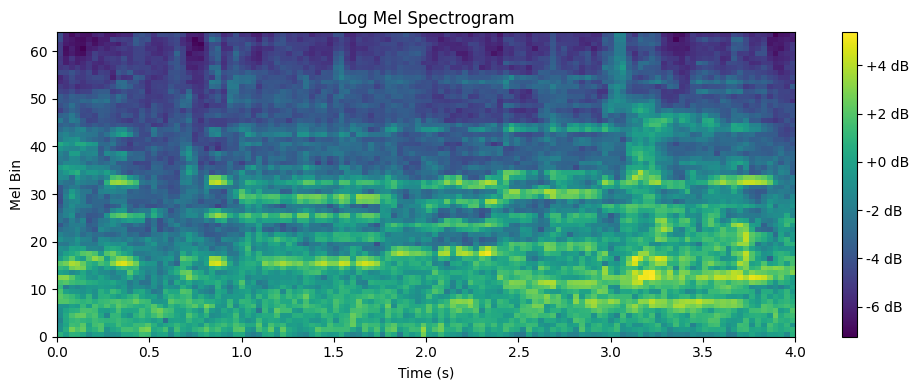

In [6]:
# Visualize log mel spectrogram
features_2d = np.squeeze(features)

plt.figure(figsize=(10, 4))
plt.imshow(features_2d, aspect='auto', origin='lower',
           extent=[0, AUDIO_CONFIG['dataset']['duration'], 
                   0, AUDIO_CONFIG['dataset']['n_mels']])
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Bin')
plt.tight_layout()
plt.show()

## Run Inference

Load the ONNX model using ONNX Runtime with the TIDL delegate and perform inference using the imported function.

In [7]:
# Set up ONNX Runtime session
delegate_options = {
    "artifacts_folder": str(artifacts_path),
    "debug_level": debug_level
}

session_options = ort.SessionOptions()
session_options.log_severity_level = 3

print(f"\nCreating ONNX Runtime session...")
execution_providers = ['TIDLExecutionProvider', 'CPUExecutionProvider']

sess = ort.InferenceSession(
    str(model_path),
    providers=execution_providers,
    provider_options=[delegate_options, {}],
    sess_options=session_options
)

print("Session created successfully\n")

# Run inference
outputs, prediction_results, benchmark_results = via.run_inference(sess, features)

# Clean up
del sess


Creating ONNX Runtime session...
Session created successfully

Shape mismatch: features=(1, 64, 126), model=[1, 1, 64, 126]
  Reshaped features to [1, 1, 64, 126]
Inference time: 9.38 ms, Output shape: (1, 10)

Top predictions (softmax probabilities):
  1. Class 9 (Street music): 0.999994
  2. Class 2 (Children playing): 0.000006
  3. Class 8 (Siren): 0.000000
  4. Class 0 (Air conditioner): 0.000000
  5. Class 1 (Car horn): 0.000000

TIDL Performance:
  Total time: 8.50 ms
  Processing time: 7.77 ms
  Copy time: 0.33 ms
  Inference time: 9.38 ms
  DDR read: 1.02 MB/s, DDR write: 16.98 MB/s


## Summary

Final results and performance overview.

In [8]:
if prediction_results and benchmark_results:
    # Use the standardized summary function from vggish_infer_audio module
    via.generate_summary_report(
        prediction_results,
        benchmark_results,
        audio_duration,
        model_name=model_name,
        tensor_bits=tensor_bits,
        audio_filename=audio_file_path.name
    )
else:
    print("Inference did not complete successfully or results were not captured.")

print("\nNotebook execution completed!")    


VGGISH11 INFERENCE SUMMARY

Audio File: 139951-9-0-9.wav
Model: vggish11_20250324-1807_ptq (int8)
Audio Duration: 4.00 seconds
Top Class: Street music (Class 9) - Confidence: 0.999994

Performance:
  Inference: 9.38 ms (TIDL: 7.77 ms, Copy: 0.33 ms)
  Throughput: RTF = 0.0023 (0.009s / 4.00s)
  Memory: 1.02 MB/s read | 16.98 MB/s write

Notebook execution completed!
